# リアルタイム Parabolic SAR (RPSAR) 改良版

### システムパスに一つ上のディレクトリ .. を追加

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

## ここでまとめてライブラリをインポート

In [2]:
import datetime
import re

from matplotlib import (
    dates as mdates,
    font_manager as fm,
    pyplot as plt,
    ticker as ticker,
)
import numpy as np
import pandas as pd
import yfinance as yf

from funcs.plots import getMajorXTicks
from funcs.preprocs_no_qt import (
    get_date_formatted,
    get_ohlc4analysis,
    get_tick4analysis,
)

from tech.rtpsar import RealTimePSAR

## 過去ログ (Tick) の読み込み

In [3]:
code = '8306'
dateStr = '20250313'
tick_excel = 'tick_%s_%s.xlsx' % (code, dateStr)
df = pd.read_excel(tick_excel)

# Tick データを Matplotlib で扱いやすいように整形
dateFmt = get_date_formatted(dateStr)
df = get_tick4analysis(df, dateFmt)
df

,Price
Datetime,
2025-03-13 09:00:00,1952.5
2025-03-13 09:00:01,1954.0
2025-03-13 09:00:04,1956.5
2025-03-13 09:00:05,1957.5
2025-03-13 09:00:07,1960.0
...,...
2025-03-13 15:24:54,1954.0
2025-03-13 15:24:56,1953.5
2025-03-13 15:24:58,1953.5


In [20]:
af_init=0.0000
af_step=0.0005
af_max=0.05
psar = RealTimePSAR(af_init, af_step, af_max)

for r in range(len(df)):
    t = df.index[r]
    price = df.loc[t, 'Price']
    psar.add(t, price)

df_psar = psar.getPSAR()
df_psar

,Price,TREND,EP,AF,PSAR,EPcount,EPPriceDelta
Datetime,,,,,,,
2025-03-13 09:00:00,1952.5,0.0,NaN,NaN,NaN,0.0,NaN
2025-03-13 09:00:01,1954.0,1.0,1954.0,0.0000,1954.000000,0.0,0.0
2025-03-13 09:00:04,1956.5,1.0,1956.5,0.0005,1954.001250,0.0,0.0
2025-03-13 09:00:05,1957.5,1.0,1957.5,0.0010,1954.004749,0.0,0.0
2025-03-13 09:00:07,1960.0,1.0,1960.0,0.0015,1954.013742,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-13 15:24:54,1954.0,-1.0,1953.0,0.0035,1957.054583,41.0,1.0
2025-03-13 15:24:56,1953.5,-1.0,1953.0,0.0035,1957.040392,42.0,0.5
2025-03-13 15:24:58,1953.5,-1.0,1953.0,0.0035,1957.026251,43.0,0.5


## チャート

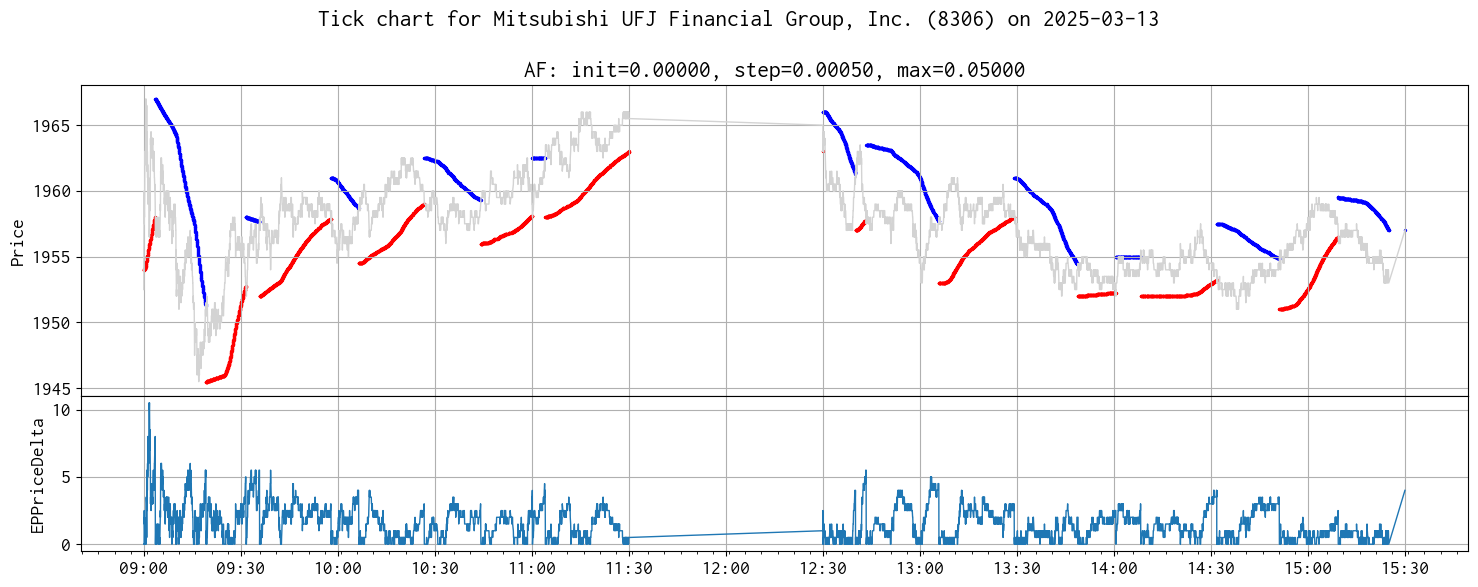

In [21]:
fig = plt.figure(figsize=(15, 6))

n = 2
gs = fig.add_gridspec(
    n, 1,
    wspace=0.0, hspace=0.0,
    height_ratios=[2 if i == 0 else 1 for i in range(n)]
)
ax = dict()
for i, axis in enumerate(gs.subplots(sharex='col')):
    ax[i] = axis
    ax[i].grid()

# Tick
ax[0].plot(df_psar['Price'], linewidth=1, color='lightgray',)

# PSAR bear - Downward trend
df_bear = df_psar[df_psar['TREND'] < 0]
ax[0].scatter(x=df_bear.index, y=df_bear['PSAR'], color='blue', s=2,)

# PSAR bull - Upward trend
df_bull = df_psar[df_psar['TREND'] > 0]
ax[0].scatter(x=df_bull.index, y=df_bull['PSAR'], color='red', s=2,)

tick_position, tick_labels = getMajorXTicks(df)
ax[0].set_xticks(ticks=tick_position, labels=tick_labels,)
ax[0].xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[0].set_ylabel('Price')

ax[0].set_title('AF: init=%.5f, step=%.5f, max=%.5f' % (af_init, af_step, af_max))

# EPPriceDelta
ax[1].plot(df_psar['EPPriceDelta'], linewidth=1, color='C0',)
ax[1].set_ylabel('EPPriceDelta')


ticker = yf.Ticker('%s.T' % code)
try:
    suptitle = 'Tick chart for %s (%s) on %s' % (ticker.info['longName'], code, dateFmt)
except KeyError:
    suptitle = 'Tick chart for %s on %s' % (code, dateFmt)

plt.suptitle(suptitle)

plt.tight_layout()
plt.savefig('screenshots/tick_chart_%s_%s.png' % (code, dateFmt))
plt.show()